## BMI-206 Course Individual Project
- Abolfazl (Abe) Arab

___
**Project plan**

In bioinformatics it’s common to have different tools for the same task. Generally, the main task we are working on is identifying cell-type specific casual enhancer-gene relationships inferred from the multi-modal mRNA and ATAC single-cell sequencing data. In addition to the SCENT approach as a peak-gene association inference method, there is a preprint that introduced the scMultiMap (Su et al., 2024) method – I found this method through searching the paper in which they cited SCENT paper. They claim to outperform in run-time (computational cost is less than 1% of SCENT and other existing methods) and statistical power. For instance, in systematic analyses of blood and brain data, scMultiMap shows appropriate type I error control, high statistical power with greater reproducibility across independent datasets and stronger consistency with orthogonal data modalities.

I will aim to apply it to the original single-cell datasets introduced in the SCENT paper. Then, I will evaluate the enhancers and target gene maps in disease-related cell types by using causal genetic variants in the genome-wide association studies (GWAS) as gold-labels. In our group project we aimed to perform more in-depth evaluations on the GWAS datasets and I will take advantage of our lessons there to extract a curated set of variants to evaluate scMultiMap outputs. Finally, I will implement a “causal variant enrichment analysis” formula through custom codes in R or python to reproduce similar analysis as described in the SCENT paper. As we move forward, we will decide what exact analysis we can perform. We have lots of examples from the sub-figures but we can also go beyond that, for instance we can evaluate what are the effects of changing covariates in the SCENT pipeline.

References:
- https://www.biorxiv.org/content/10.1101/2024.09.24.614814v1.full 
- https://changsubiostats.github.io/scMultiMap/articles/scMultiMap.html 

___

- https://stuartlab.org/signac/articles/pbmc_multiomic

In [ ]:
# !conda install -y bioconda::bioconductor-ensdb.hsapiens.v86
# !conda install -y bioconda::bioconductor-bsgenome.hsapiens.ucsc.hg38
# !conda install -y bioconda::bioconductor-biovizbase

In [99]:
%load_ext rpy2.ipython

In [100]:
%%R
library('scMultiMap')
library('SCENT')
library('Signac')
library('Seurat')
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(tidyverse)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks Biostrings::collapse(), IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ purrr::compact()      masks XVector::compact()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks ensembldb::filter(), stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ 

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Loading required package: ensembldb
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:SeuratObject’:

    intersect

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: GenomicRanges
Loading required package: stats4
Loading required packa

In [101]:
%%R
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevels(annotation) <- paste0('chr', seqlevels(annotation))

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~01m 30s       |++++                                              | 8 % ~01m 04s       |++++++                                            | 12% ~01m 11s       |++++++++                                          | 16% ~01m 03s       |++++++++++                                        | 20% ~59s           |++++++++++++                                      | 24% ~57s           |++++++++++++++                                    | 28% ~53s           |++++++++++++++++                                  | 32% ~49s           |++++++++++++++++++                                | 36% ~45s           |++++++++++++++++++++                              | 40% ~42s           |++++++++++++++++++++++                            | 44% ~41s           |++++++++++++++++++++++++                          | 48% ~37s           |++++++++++++++++++++++++++                        | 52% ~34s 

In addition: There were 24 warnings (use warnings() to see them)


In [102]:
%%R
readRDS('data/sc-datasets/SCENT_obj_all.rds') -> SCENT_obj_all

In [103]:
# %%R
# readRDS('data/sc-datasets/atac_matrix.rds') -> atac_matrix
# readRDS('data/sc-datasets/rna_matrix.rds') -> rna_matrix

In [104]:
%%R
CreateSeuratObject(counts = SCENT_obj_all@rna, assay = "RNA", project = "BMI206") -> rna

In [105]:
%%R
rna

An object of class Seurat 
36601 features across 31547 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts


In [106]:
# %%R
# CreateSeuratObject(counts = SCENT_obj_all@atac, assay = "ATAC", project = "BMI206") -> atac

In [107]:
# %%R
# atac

___

In [108]:
# %%R
# fragpath = ''

In [109]:
%%R
data <- rna

data[['ATAC']] <- CreateChromatinAssay(
  counts = SCENT_obj_all@atac,
  sep = c(":", "-"),
  annotation = annotation,
  # fragments = fragpath,
  # genome = 'hg38'
)

In [110]:
%%R
data

An object of class Seurat 
169121 features across 31547 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC


In [111]:
# %%R
# DefaultAssay(data) <- "ATAC"

# data <- NucleosomeSignal(data)
# data <- TSSEnrichment(data)


# DensityScatter(data, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

In [112]:
# %%R
# data$peak

In [117]:
%%R
get_top_peak_gene_pairs(
    obj = data,
    gene_top=20000, 
    peak_top=50000,
    distance = 5e+5, # 500kb
    peak_assay = 'ATAC',
) -> pairs_df

In [118]:
%%R
pairs_df %>% dim()

[1] 589364      2


In [119]:
%%R

start <- Sys.time()
res <- scMultiMap(
    data, 
    pairs_df,
    gene_assay = 'RNA',
    peak_assay = 'ATAC',
)
end <- Sys.time() 
end - start

[1] "Start step 1: IRLS"
[1] "Start IRLS for RNA"
[1] "Start IRLS for ATAC"
[1] "Start step 2: WLS"
[1] "There are 14974 unique genes in the peak-gene pairs."
Time difference of 1.328301 hours


In addition: There were 18 warnings (use warnings() to see them)


In [120]:
%%R

res %>% write.table('data/sc-datasets/scMultiMap_res.tsv', sep='\t', quote=FALSE, row.names=FALSE)

### Exploratory Data Analysis (EDA)

___
A data frame of SCENT results with these columns.

    gene	The gene(-peak) pair in each test statistics
    peak	The (gene-)peak pair in each test statistics
    beta	The regression coefficient from primary Poisson regression
    se	The standard error from primary Poisson regression
    z	The Z score from primary Poisson regression
    p	The raw p value from primary Poisson regression
    boot_basic_p	The bootstrap p value calculated from bootstrapping analyses


___
A data frame of scMultiMap results with five columns.

    gene    gene in the peak-gene pair
    peak    peak in the peak-gene pair
    pval    p-value
    test_stat   test statistics
    covar   estimated covariance

Each row corresponds to one peak-gene pair's results from scMultiMap. `pval` and `test_stat` denote the statistical significance of peak-gene association, and `covar` denote the magnitude of association. The number of rows is equal to the number of pairs in `pairs_df` present in the `Seurat` object.
___

In [1]:
import pandas as pd
import numpy as np
from genomicranges import GenomicRanges

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from venn import venn

set_matplotlib_formats('png')
mpl.rcParams['figure.dpi'] = 300


def read_scent_output(file):
    
    res = pd.read_csv(file, sep=' ')

    res['seqnames'] = res['peak'].str.split(':').str[0]
    res['starts'] = res['peak'].str.split(':').str[1].str.split('-').str[0].astype(int)
    res['ends'] = res['peak'].str.split(':').str[1].str.split('-').str[1].astype(int)

    res['-log10(p)'] = -np.log10(res['p'])
    res['-log10(boot_basic_p)'] = -np.log10(res['boot_basic_p'])

    res = res.set_index(['seqnames', 'starts', 'ends','peak','gene']).reset_index()

    res.index = res['peak'].str.replace(':','-') + '::' + res['gene']

    return res


def read_scmultimap_output(file):
    res = pd.read_csv(file, sep='\t')

    res['seqnames'] = res['peak'].str.split('-').str[0]
    res['starts'] = res['peak'].str.split('-').str[1].astype(int)
    res['ends'] = res['peak'].str.split('-').str[2].astype(int)


    res['-log10(pval)'] = -np.log10(res['pval'])
    res['-log10(padj)'] = -np.log10(res['padj'])


    res = res.set_index(['seqnames', 'starts', 'ends','peak','gene']).reset_index()
    res.index = res['peak'] + '::' + res['gene']

    return res

In [2]:
res_scmultimap = read_scmultimap_output('data/sc-datasets/scMultiMap_res.tsv')

/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
res_scent = read_scent_output('data/scent-results/500kb_Tcell_allcvar.txt.gz')

/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


___

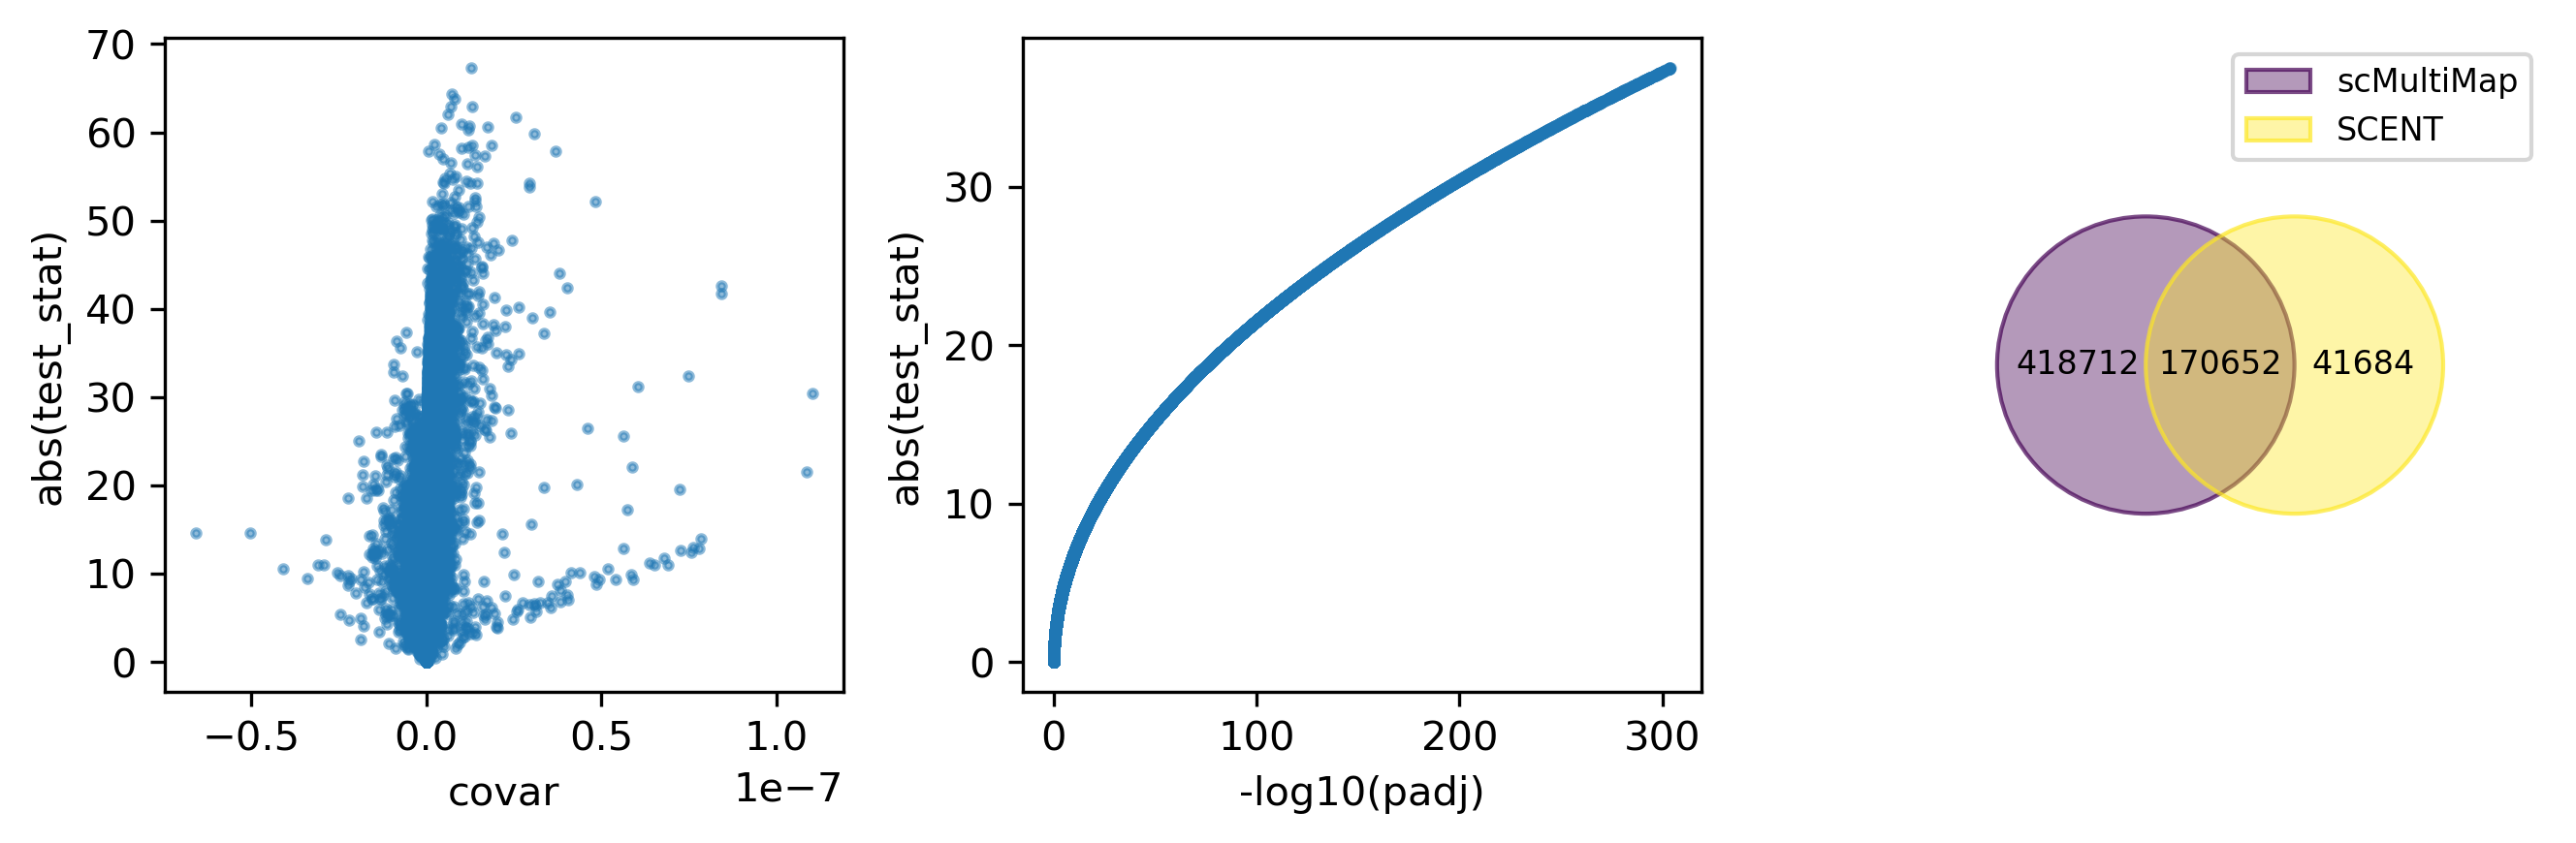

In [4]:
%matplotlib inline

fig, (ax, bx, cx) = plt.subplots(1,3, figsize=(9, 3))

x_col = 'covar'
y_col = 'test_stat'
ax.plot(res_scmultimap[x_col], res_scmultimap[y_col].abs(), 'o', alpha=0.5, markersize=2)

ax.set_xlabel(x_col)
ax.set_ylabel(f'abs({y_col})')

x_col = '-log10(padj)'
y_col = 'test_stat'

bx.plot(res_scmultimap[x_col], res_scmultimap[y_col].abs(), 'o', alpha=0.5, markersize=2)

bx.set_xlabel(x_col)
bx.set_ylabel(f'abs({y_col})')

venn({
    'scMultiMap': set(res_scmultimap.index),
    'SCENT': set(res_scent.index),
}, ax=cx, fontsize=8)

plt.tight_layout()
plt.show()

___

Build the overlap between SCENT and scMultiMap results.

In [5]:
res_ol = pd.concat([
        res_scmultimap, res_scent
    ], 
    axis=1, 
    keys=['scMultiMap', 'SCENT'],
    join='inner'
)

In [6]:
res_ol['SCENT'].columns

Index(['seqnames', 'starts', 'ends', 'peak', 'gene', 'beta', 'se', 'z', 'p',
       'boot_basic_p', '-log10(p)', '-log10(boot_basic_p)'],
      dtype='object')

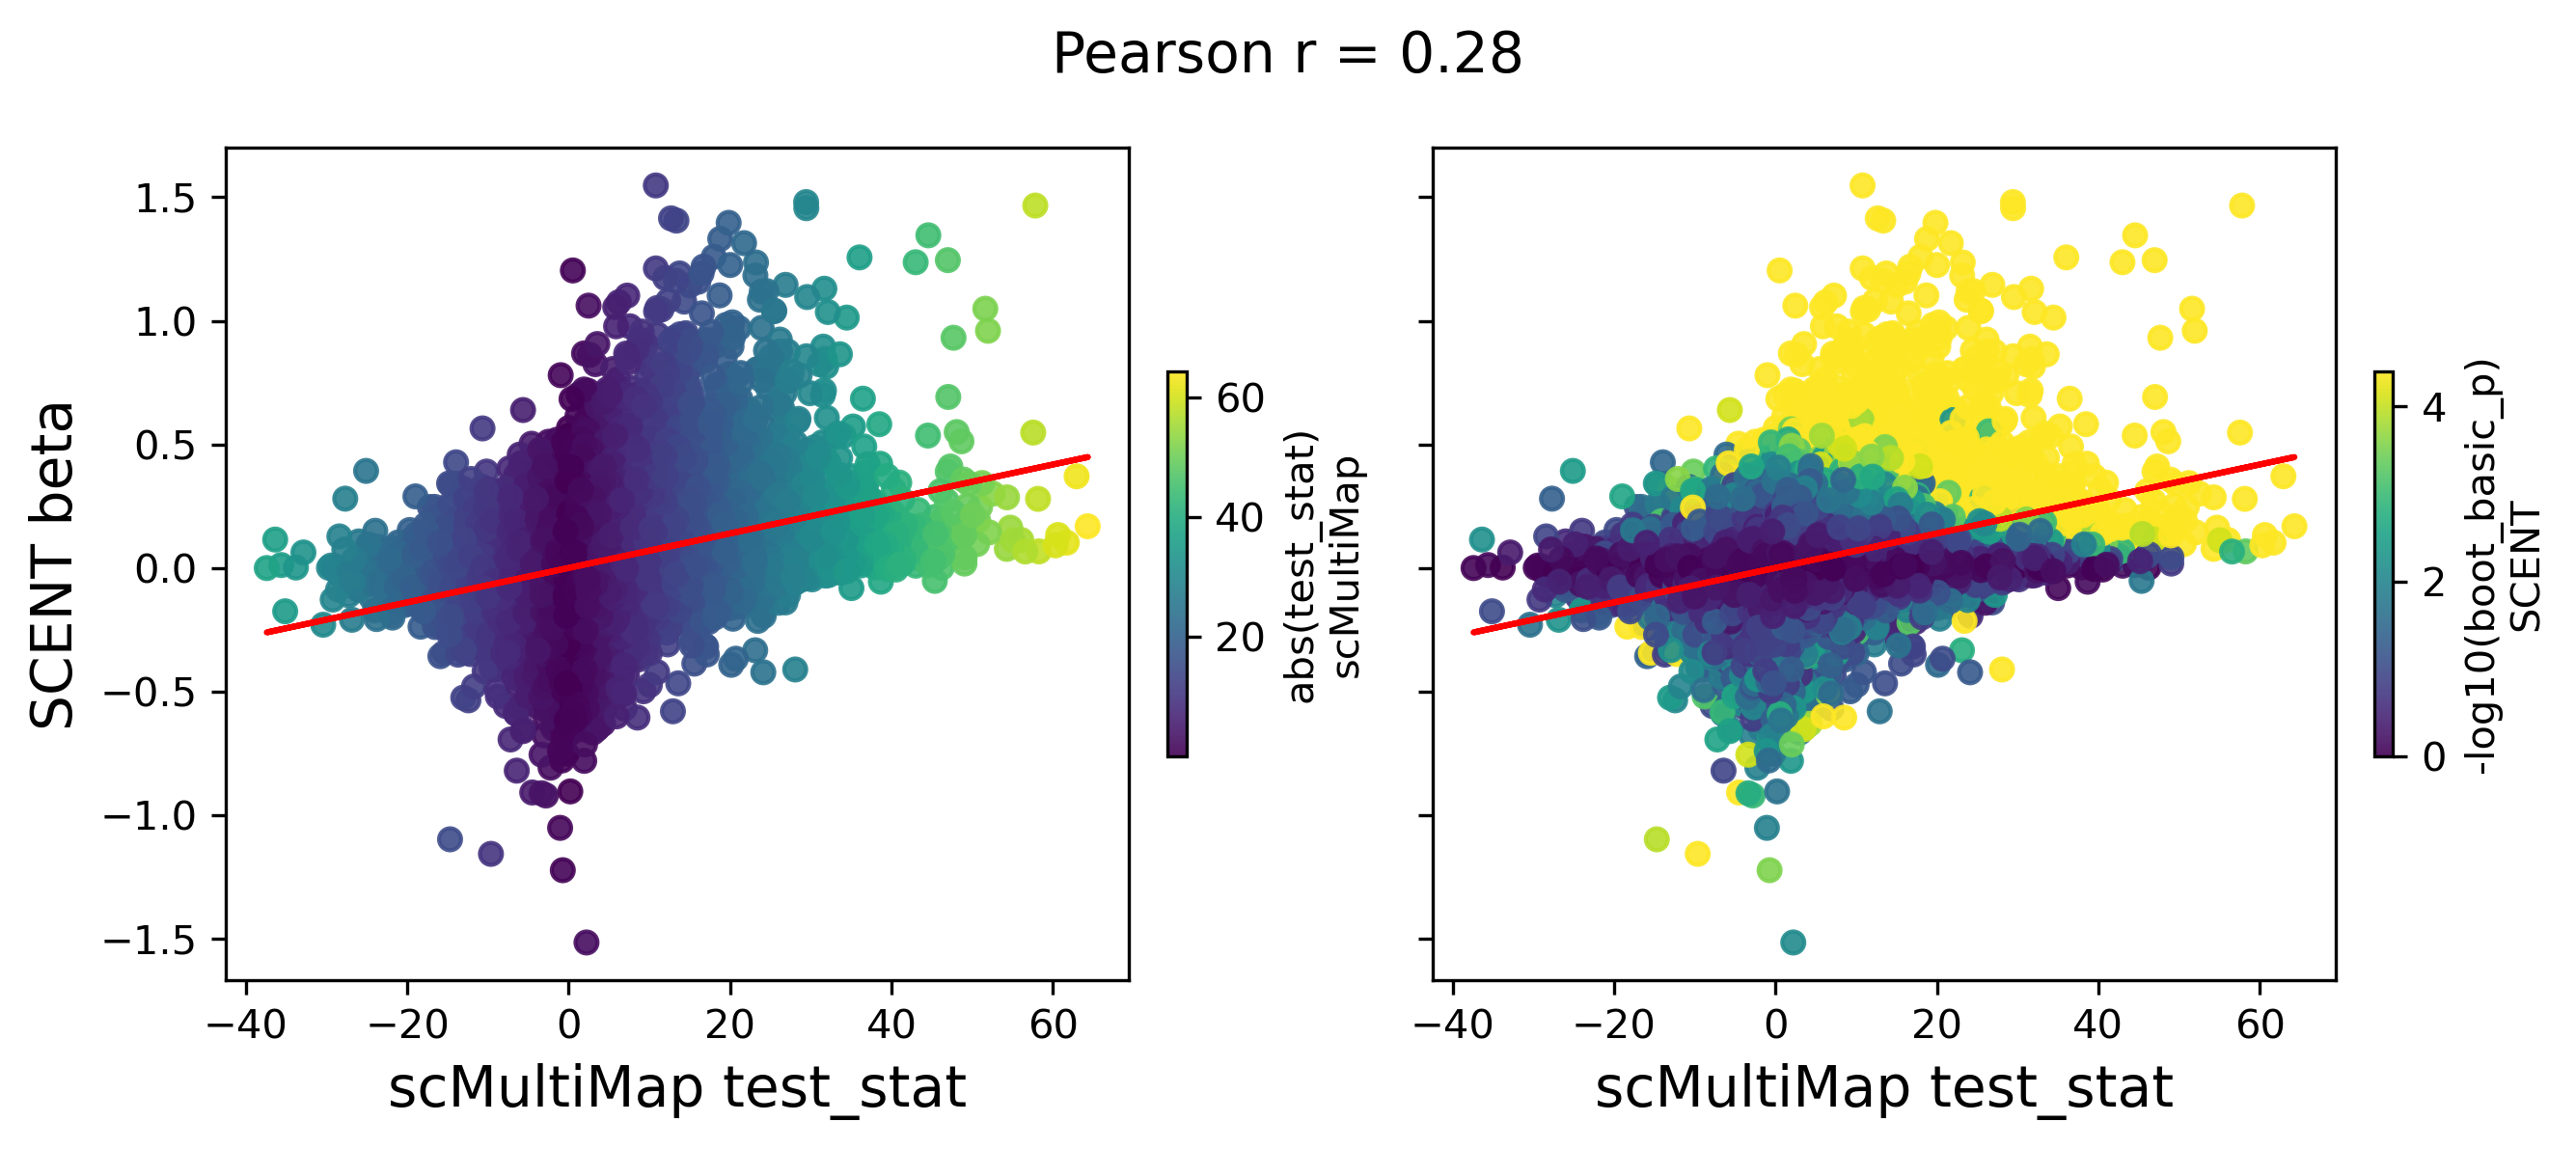

In [7]:
# Calculate coefficients for a linear trendline
fig, (ax,bx) = plt.subplots(1,2, figsize=(9, 4), sharey=True)

x = res_ol['scMultiMap']['test_stat']
y = res_ol['SCENT']['beta']
m, b = np.polyfit(x, y, 1)
corr = pd.concat([x, y], axis=1).corr().iloc[0,1]

ax.scatter(
    x=x, y=y,
    c=res_ol['scMultiMap']['test_stat'].abs(),cmap='viridis',
    alpha=0.9, s=30
)

# color bar (small size)
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('abs(test_stat)\nscMultiMap')
cbar.set_alpha(1)


# Add trendline to plot
ax.plot(x, m*x + b, color='red')

ax.set_xlabel('scMultiMap test_stat', fontsize=14)
ax.set_ylabel('SCENT beta', fontsize=14)

bx.scatter(
    x=x, y=y,
    c=res_ol['SCENT']['-log10(boot_basic_p)'],cmap='viridis',
    alpha=0.9, s=30
)

# color bar (small size)
cbar = plt.colorbar(bx.collections[0], ax=bx, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('-log10(boot_basic_p)\nSCENT', fontsize=10)
cbar.set_alpha(1)

bx.set_xlabel('scMultiMap test_stat', fontsize=14)

# Add trendline to plot
bx.plot(x, m*x + b, color='red')

plt.suptitle(f'Pearson r = {corr:.2f}', fontsize=14)
plt.tight_layout()
plt.show()

___

In [8]:
fine_map_df = pd.read_csv(
    "data/fine_map/all_finngen_trait_cs_filtered.tsv",
    sep='\t'
)

fine_map_df['seqnames'] = fine_map_df['region'].str.split(':').str[0]
# fine_map_df['starts'] =  fine_map_df['position'].astype(int) - 100
# fine_map_df['ends'] =    fine_map_df['position'].astype(int) + 100
fine_map_df['starts'] =  fine_map_df['region'].str.split(':').str[1].str.split('-').str[0].astype(int)
fine_map_df['ends'] =    fine_map_df['region'].str.split(':').str[1].str.split('-').str[1].astype(int)

fine_map_df = fine_map_df.set_index(['seqnames', 'starts', 'ends']).reset_index()

___

In [9]:
res_gr = GenomicRanges.from_pandas(res_ol['scMultiMap'].query('padj < 0.01').iloc[:, :3])
fine_map_gr = GenomicRanges.from_pandas(fine_map_df.iloc[:, :3])

# print(res_gr)
# print(fine_map_gr)

In [10]:
res_fine_map_gr = res_gr.subset_by_overlaps(fine_map_gr, query_type="within")

In [11]:
res_fine_map_gr.to_pandas().shape[0] / res_scmultimap.shape[0]

0.06730645237917483

In [12]:
res_ol_gwas = res_ol.loc[res_fine_map_gr.to_pandas().index.to_list(),:].copy()

In [13]:
fine_map_df.shape

(2663, 18)

In [14]:
res_ol_gwas.shape

(39668, 24)

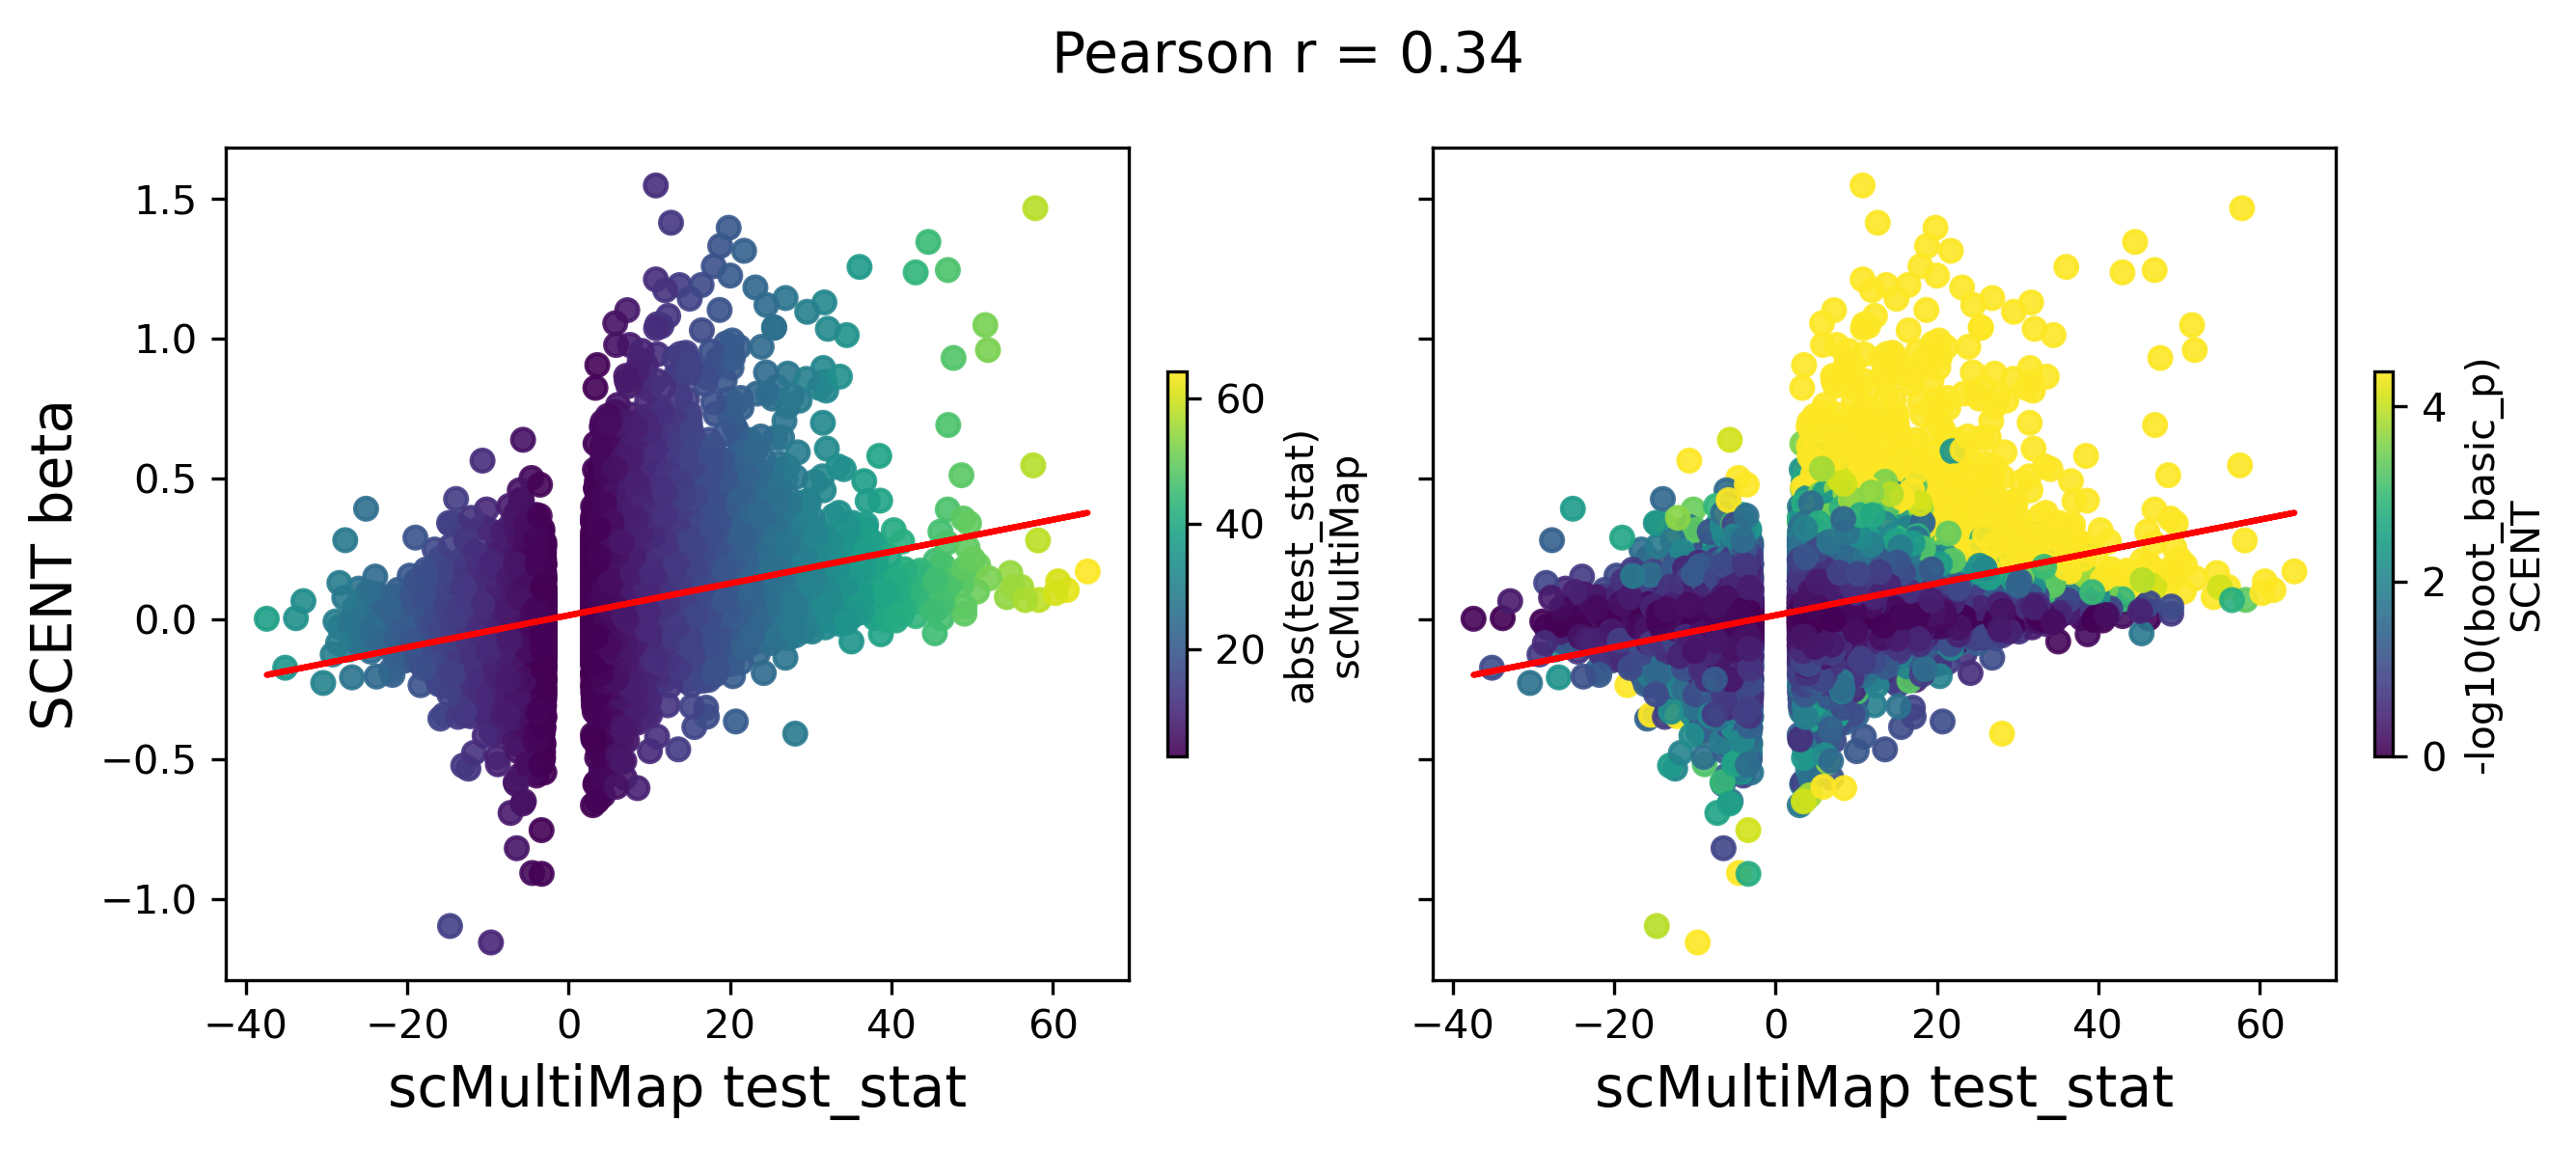

In [15]:
fig, (ax,bx) = plt.subplots(1,2, figsize=(9, 4), sharey=True)

x = res_ol_gwas['scMultiMap']['test_stat']
y = res_ol_gwas['SCENT']['beta']
m, b = np.polyfit(x, y, 1)
corr = pd.concat([x, y], axis=1).corr().iloc[0,1]

ax.scatter(
    x=x, y=y,
    c=res_ol_gwas['scMultiMap']['test_stat'].abs(),cmap='viridis',
    alpha=0.9, s=30
)

# color bar (small size)
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('abs(test_stat)\nscMultiMap')
cbar.set_alpha(1)


# Add trendline to plot
ax.plot(x, m*x + b, color='red')

ax.set_xlabel('scMultiMap test_stat', fontsize=14)
ax.set_ylabel('SCENT beta', fontsize=14)

bx.scatter(
    x=x, y=y,
    c=res_ol_gwas['SCENT']['-log10(boot_basic_p)'],cmap='viridis',
    alpha=0.9, s=30
)

# color bar (small size)
cbar = plt.colorbar(bx.collections[0], ax=bx, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('-log10(boot_basic_p)\nSCENT', fontsize=10)
cbar.set_alpha(1)

bx.set_xlabel('scMultiMap test_stat', fontsize=14)

# Add trendline to plot
bx.plot(x, m*x + b, color='red')

plt.suptitle(f'Pearson r = {corr:.2f}', fontsize=14)
plt.tight_layout()
plt.show()

___

In [16]:
import sys

sys.path.append('code')

import regionperm

In [17]:
help(regionperm.run)

Help on function run in module regionperm:

run(A_region_set, B_region_set, universe_region_set, num_iterations, match_by)
    Genomic region association analysis with permutation tests.

    Assess the association between a set of genomic regions and other genomic features using permutation tests.

    Parameters:
    A_region_set: the set of regions to randomize in BED format.
    B_region_set: the set of genomic features that will be analyzed for their association with the regions in A_region_set in BED format.
    universe_region_set: the total valid regions from which subsequent random iterations will be sampled from in BED format. A_region_set is a subset of the universe_region_set.
    num_iterations: number of iterations for permutation test.
    match_by: for each iteration, randomize regions by matching the count or length of the original A region set. choices=['count', 'length']



### run `regionperm` for the scMultiMap

In [21]:
q_r = res_scmultimap.test_stat.quantile(0.95)
q_l = res_scmultimap.test_stat.quantile(0.5)

res_scmultimap.query('test_stat > @q_r or test_stat < @q_l').shape

(324151, 13)

/pollard/home/aabe/BMI-206-Class-Project/code/regionperm.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fragment_length'] = df.apply(lambda row: row.iloc[2]-row.iloc[1], axis=1)
/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pybedtools/bedtool.py:3687: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 33 fields; you can supply custom names with the `names` kwarg
  warn(
Permutation simulations in progress: 100% |███████████████████████████████████████| 50/50 simulation


Original evaluation: 1224
Alternative: less
P-value: 0.3137254901960784
Z-score: -0.24128650621650044

Done.
Time elapsed: 22.67 minutes.


,p_value,z_score,n_iterations,alternative,original_evaluation,complement_evaluation,universe_evaluation
0,0.313725,-0.241287,50,less,1224,779,1227


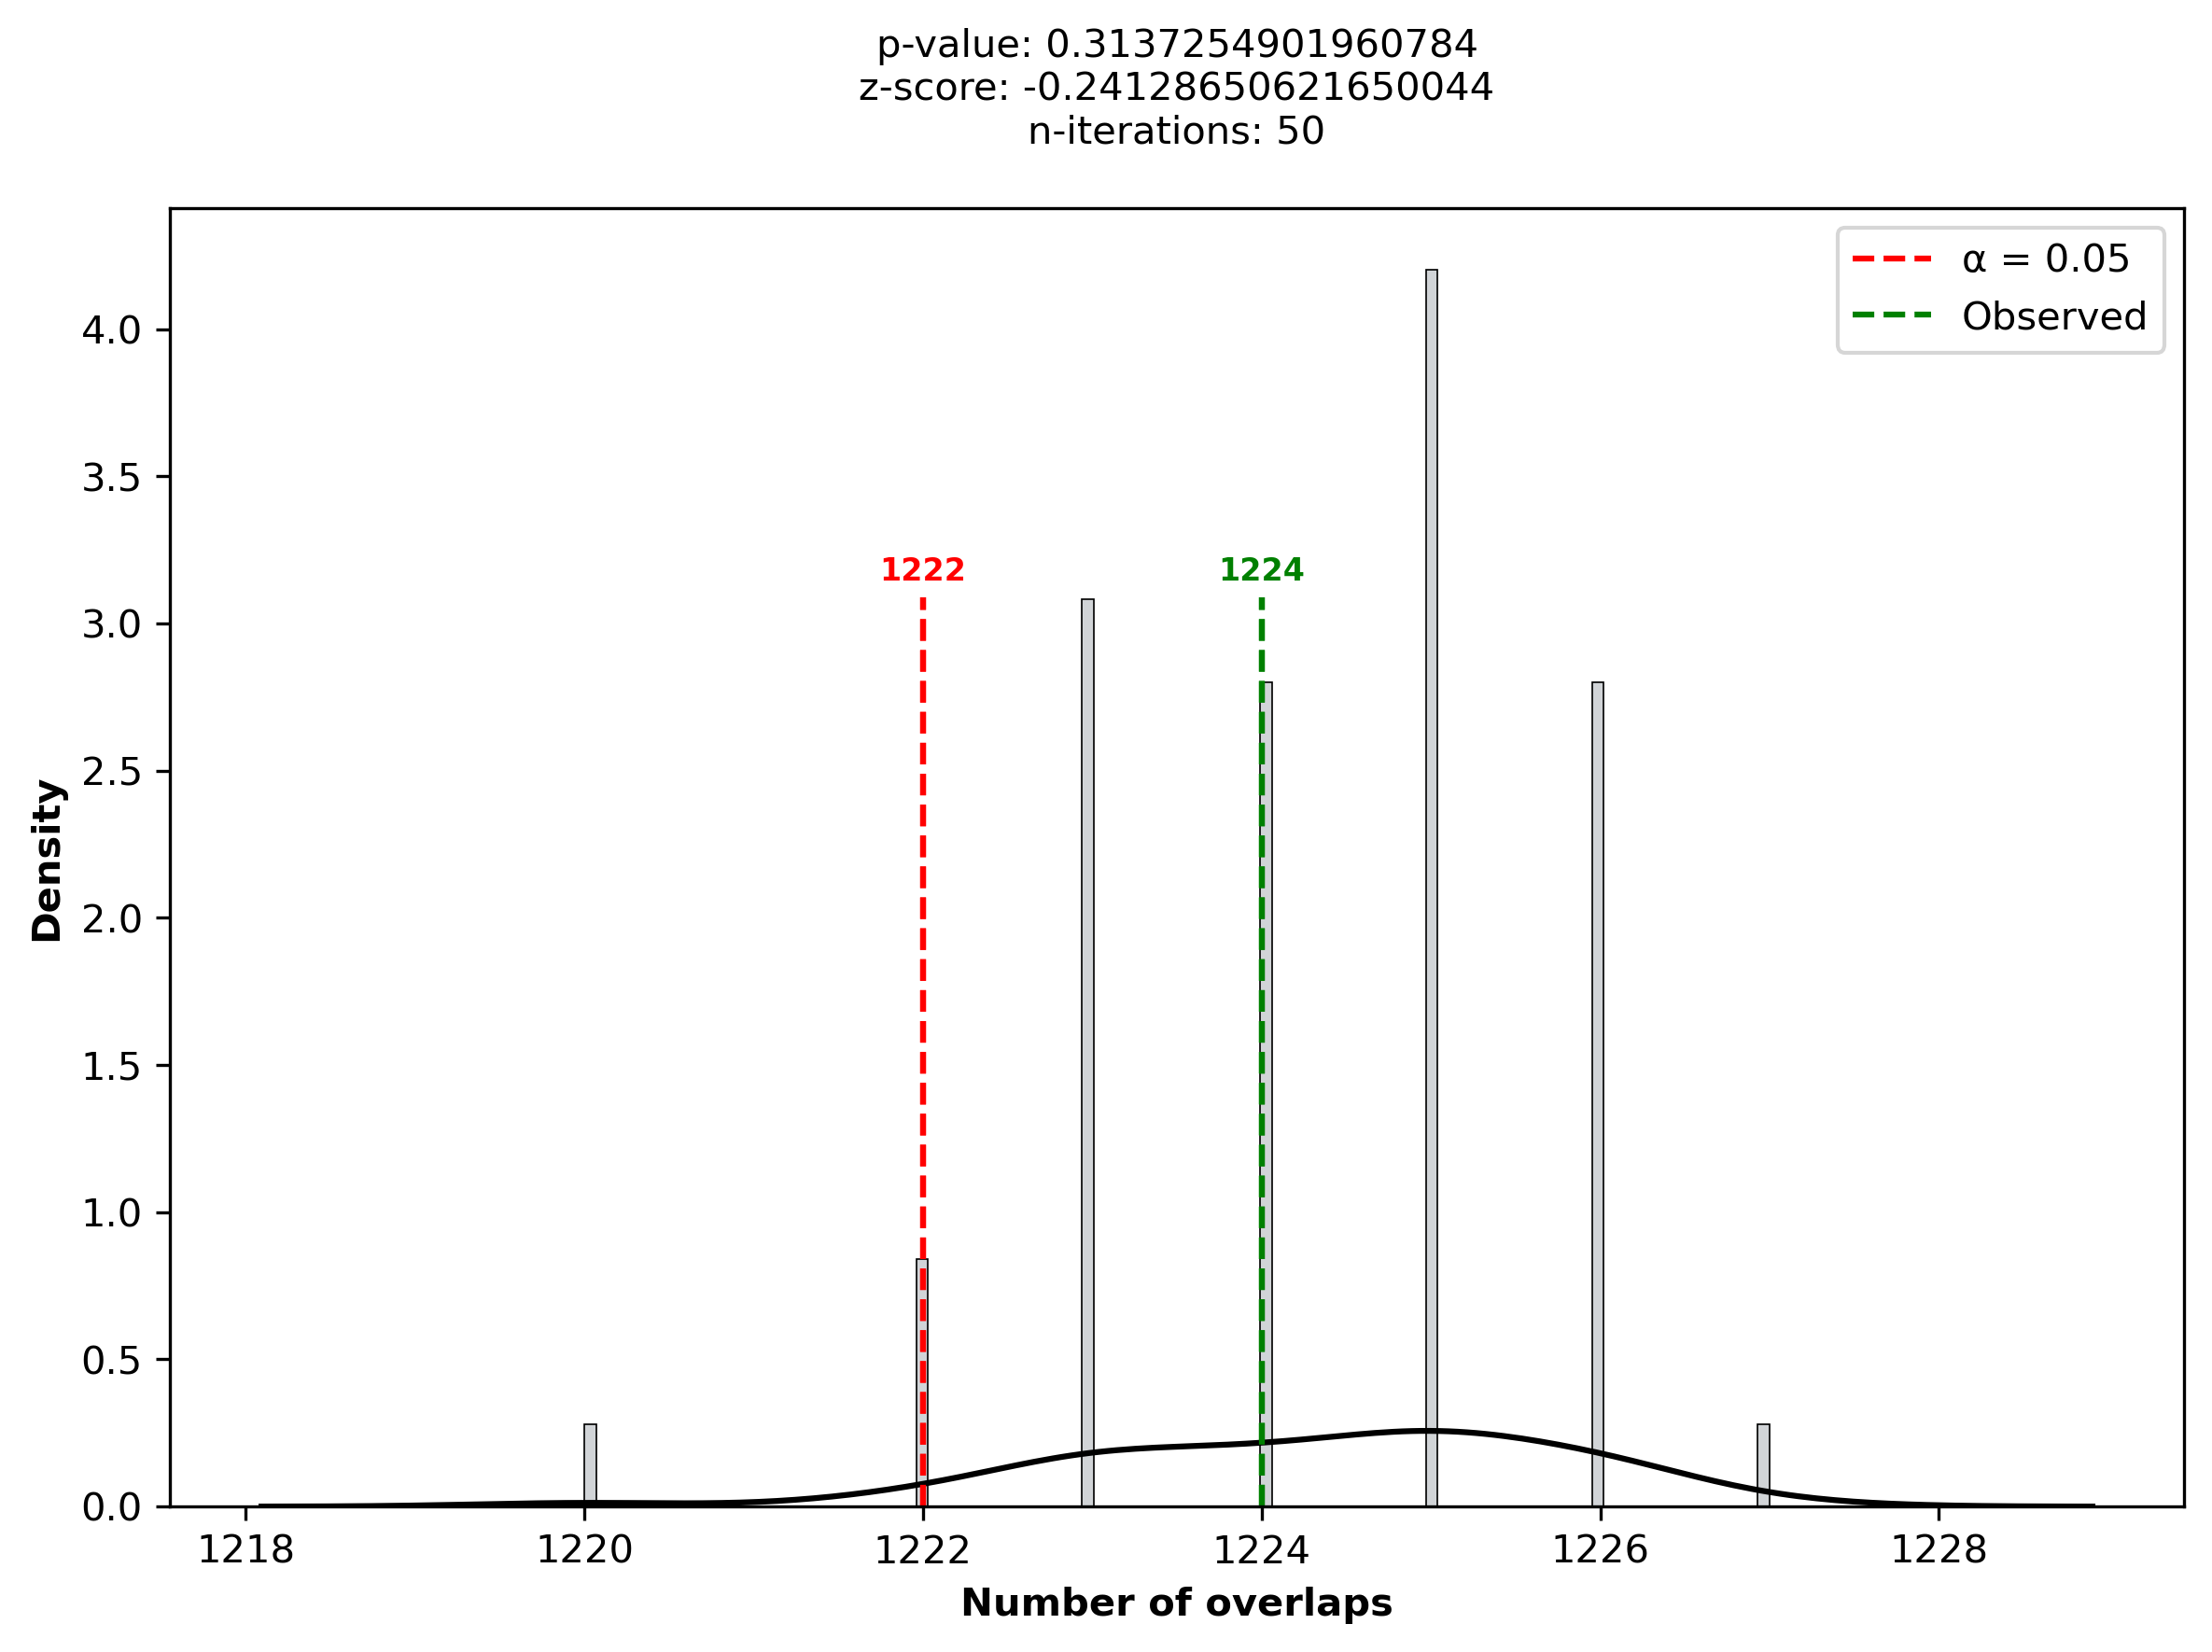

In [56]:
regionperm.run(
    A_region_set = res_scmultimap.query('test_stat > @q_r or test_stat < @q_l'),
    B_region_set = fine_map_df,
    universe_region_set = res_scmultimap,
    num_iterations = 50,
    match_by = 'count'
)

In [20]:
# regionperm.run(
#     A_region_set = res_ol['SCENT'].query('-log10(boot_basic_p) > 1'),
#     B_region_set = fine_map_df,
#     universe_region_set = res_ol['SCENT'],
#     num_iterations = 1000,
#     match_by = 'count'
# )

In [21]:
# regionperm.run(
#     A_region_set = res_ol['scMultiMap'].query('-log10(padj) > 1'),
#     B_region_set = fine_map_df,
#     universe_region_set = res_ol['scMultiMap'],
#     num_iterations = 1000,
#     match_by = 'count'
# )

In [22]:
# res_scmultimap.query('-log10(padj) > 1').shape[0]

In [23]:
# regionperm.run(
#     A_region_set = res_scmultimap.query('-log10(padj) > 2'),
#     B_region_set = fine_map_df,
#     universe_region_set = res_scmultimap,
#     num_iterations = 10,
#     match_by = 'count'
# )

In [24]:
# regionperm.run(
#     A_region_set = res_ol['scMultiMap'].query('test_stat > @q_r or test_stat < @q_l').copy(), # FDR < 0.1 ?
#     B_region_set = fine_map_df,
#     universe_region_set = res_ol['scMultiMap'],
#     num_iterations = 1000,
#     match_by = 'count'
# )

### Pathway analysis using pyPAGE

In [23]:
import sys

import pypage
from pypage import ExpressionProfile
from pypage import GeneSets
from pypage import PAGE

pagerdir='/pollard/home/aabe/tools/pager'

sys.path.append(pagerdir)

import pager

def load_annotation(ann_file):
    gs_ann = GeneSets(ann_file=ann_file, n_bins=3)
    return gs_ann


def load_expression(df, n_bins=10):
    # df = pd.read_csv(expression_file,
    #                  sep="\t",
    #                  header=0,
    #                  names=["gene", "exp"])
    exp = ExpressionProfile(df.iloc[:, 0],
                            df.iloc[:, 1],
                            n_bins=n_bins)
    # exp.convert_from_to('refseq', 'ensg', 'human')
    return exp


def subset_results(p, sides=['up','down'], clusts=[1,2,3], thr=0.001):
    dfs = []
    
    for s in sides:
        for n in clusts:
            df = pager.pvmat2bio_signal(
                p.get_es_matrix(),
                side=s,n_clust=n,
                thr = -np.log10(thr)
            ) 
            dfs.append(df)
    
    return pd.concat(dfs)
        

def draw_heatmap(es_matrix,cmap = 'viridis'):
    # https://github.com/goodarzilab/pypage/issues/46
    return pypage.heatmap.Heatmap(pathways=es_matrix.index,graphical_ar=es_matrix.to_numpy(),cmap_main = cmap)


def run_pyPAGE(expression, annotation,threads=18):
    p = PAGE(
        expression,
        annotation,
        n_shuffle=1000,
        n_jobs=threads,
        # Hani: _"You must redo iPAGE with `--independence=0` option for comparing results between multiple smaples."_        
        filter_redundant=False
    )
    
    _,_ = p.run()
    
    return p

In [24]:
msigdb_c5_gobp = load_annotation(f'{pagerdir}/annotations/human/msigdb_v7.4_c5.go.bp/c5.go.bp.v7.4.symbols.gmt')

In [25]:
# # !pip uninstall -y bio-pypage
# !pip install git+https://github.com/goodarzilab/pypage

In [26]:
# del run_pyPAGE

In [27]:
page_scmultimap = run_pyPAGE(
    load_expression(
        res_scmultimap[['gene','test_stat']].copy(),
        n_bins=20
    ),
    msigdb_c5_gobp
)

permutation testing:   3%|▎         | 238/7481 [00:08<04:29, 26.88it/s]
hypergeometric tests: 199it [00:00, 528.36it/s]


In [28]:
p = page_scmultimap

In [29]:
# s = 'down'
# n = 1

# pager.pvmat2bio_signal(
#     p.get_es_matrix(),
#     side=s,n_clust=n,
#     thr = -np.log10(0.001)
# )

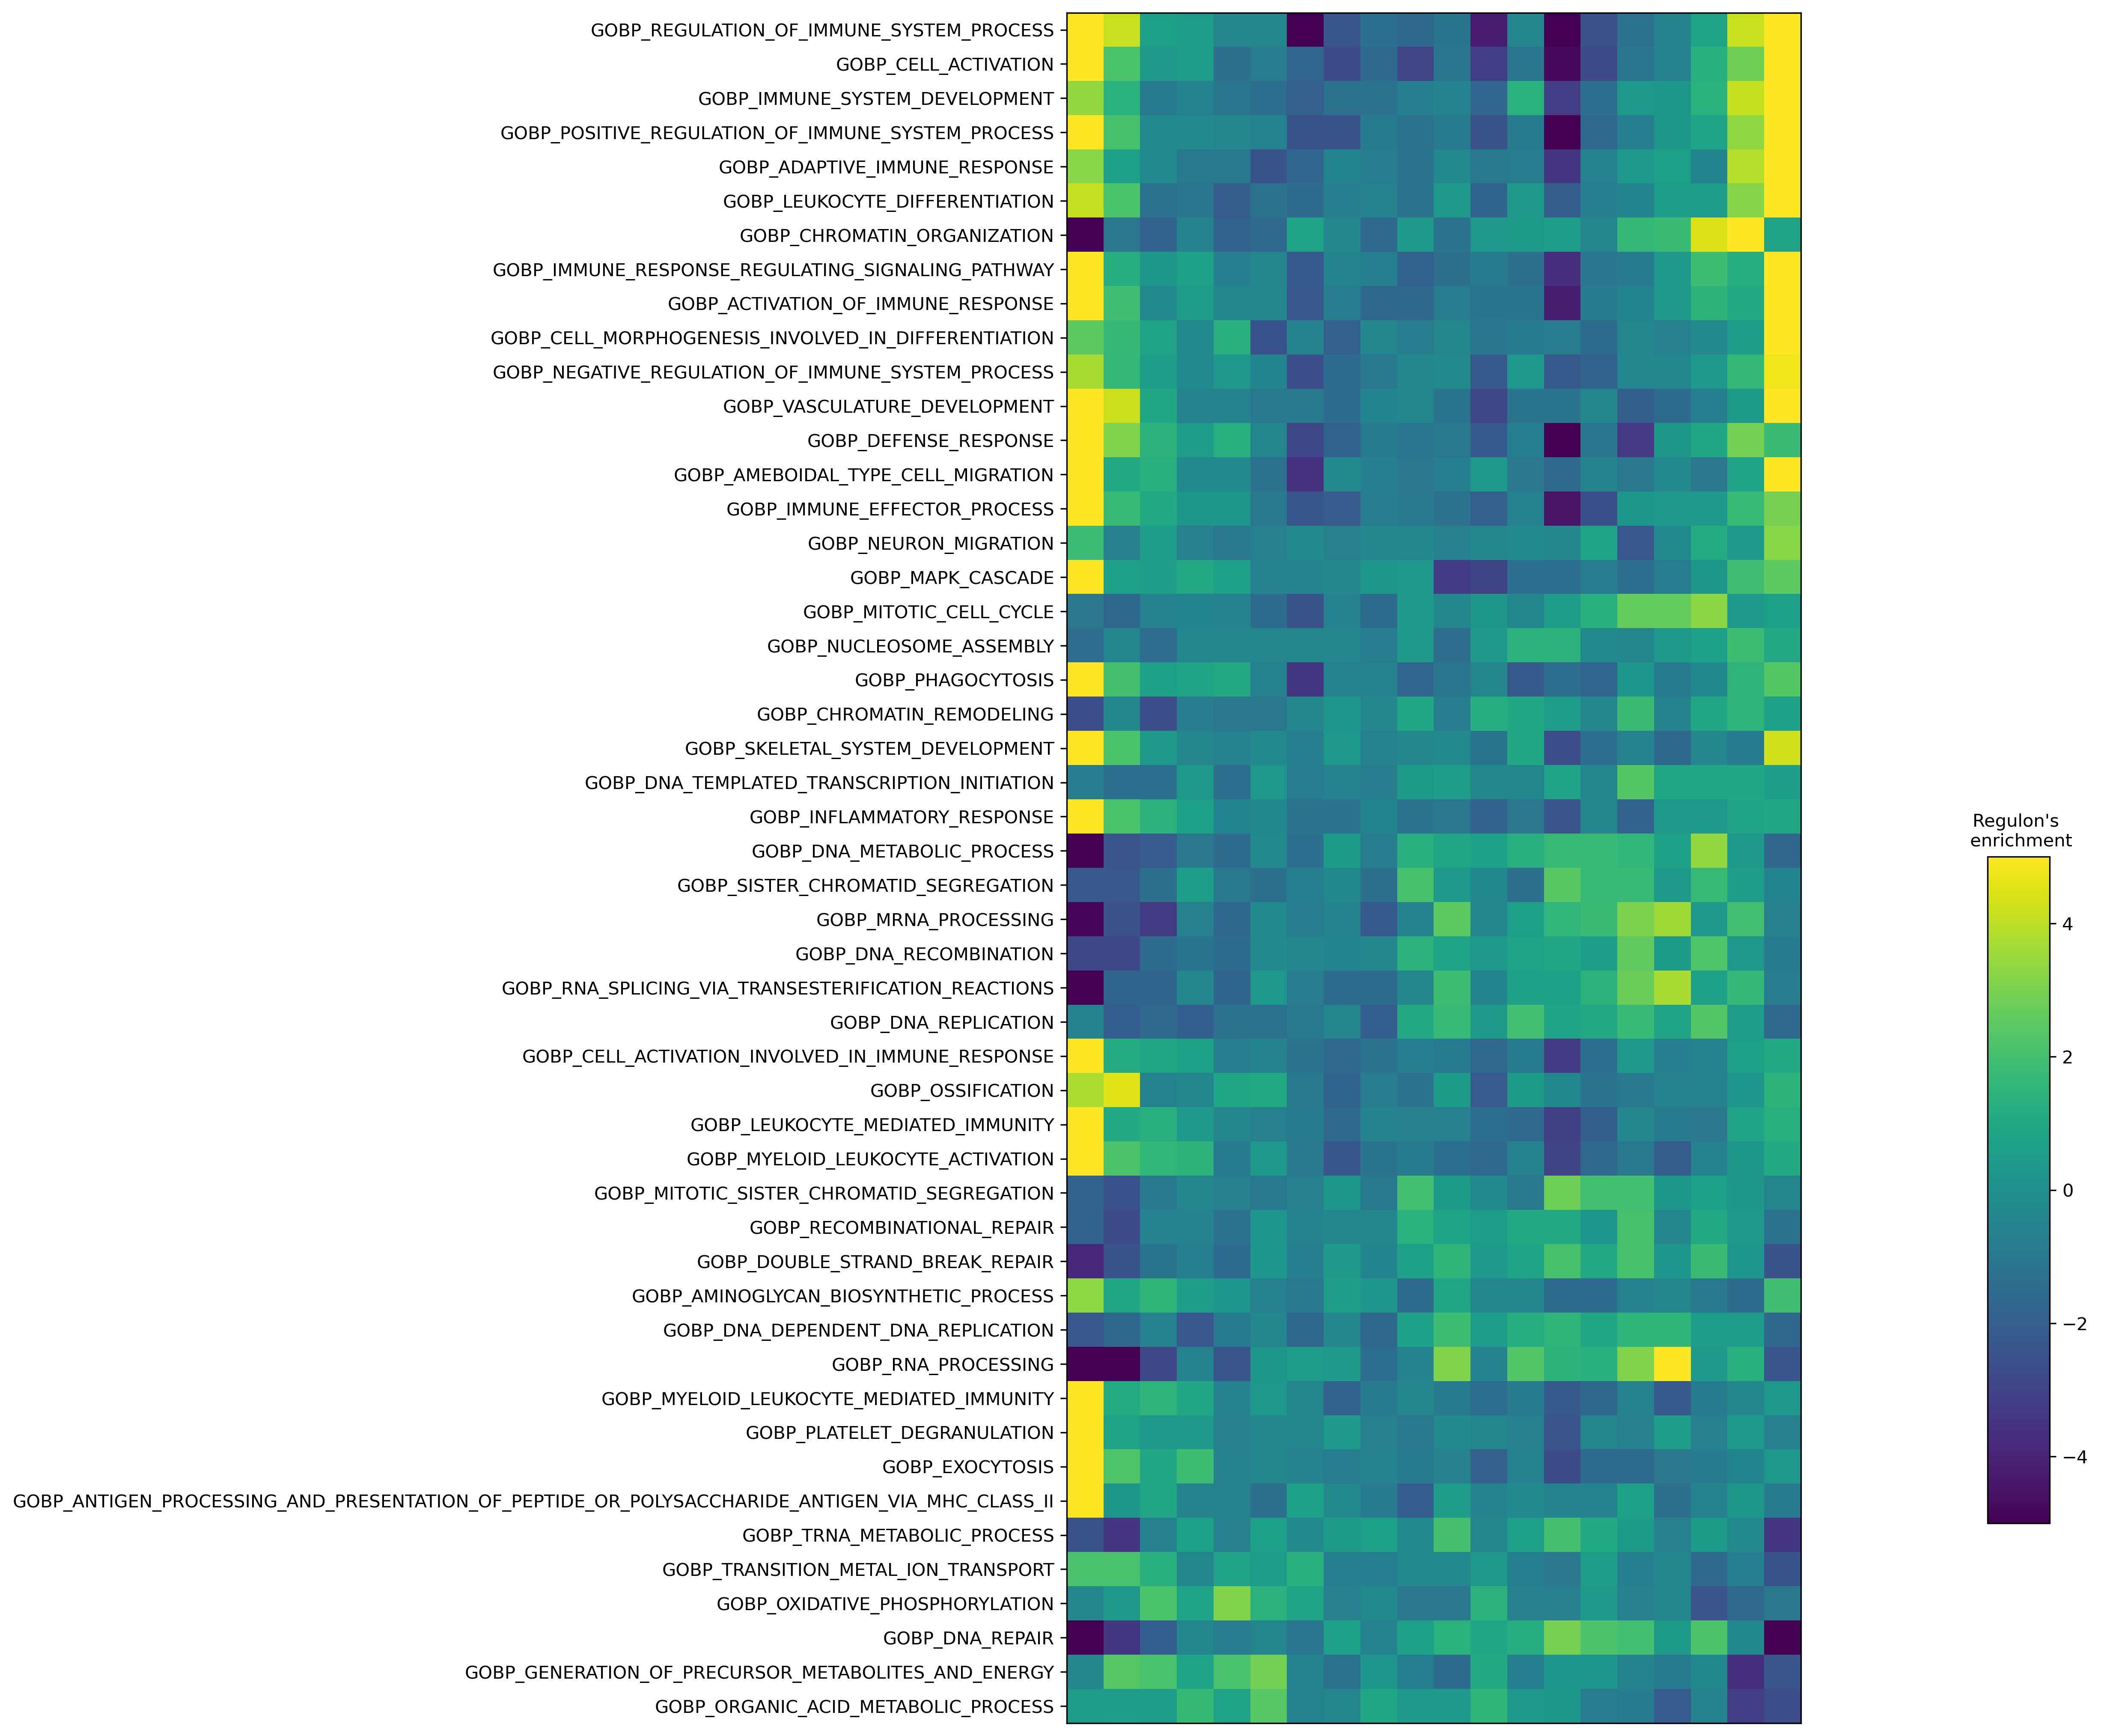

In [30]:
draw_heatmap(page_scmultimap.get_es_matrix()).show()

In [32]:
%matplotlib inline

# es_mat = page_scmultimap.get_es_matrix()
es_mat = subset_results(
    page_scmultimap,
    sides=['up','down','both'],
    clusts=[1,2,3,4],
    thr=10**-3
)

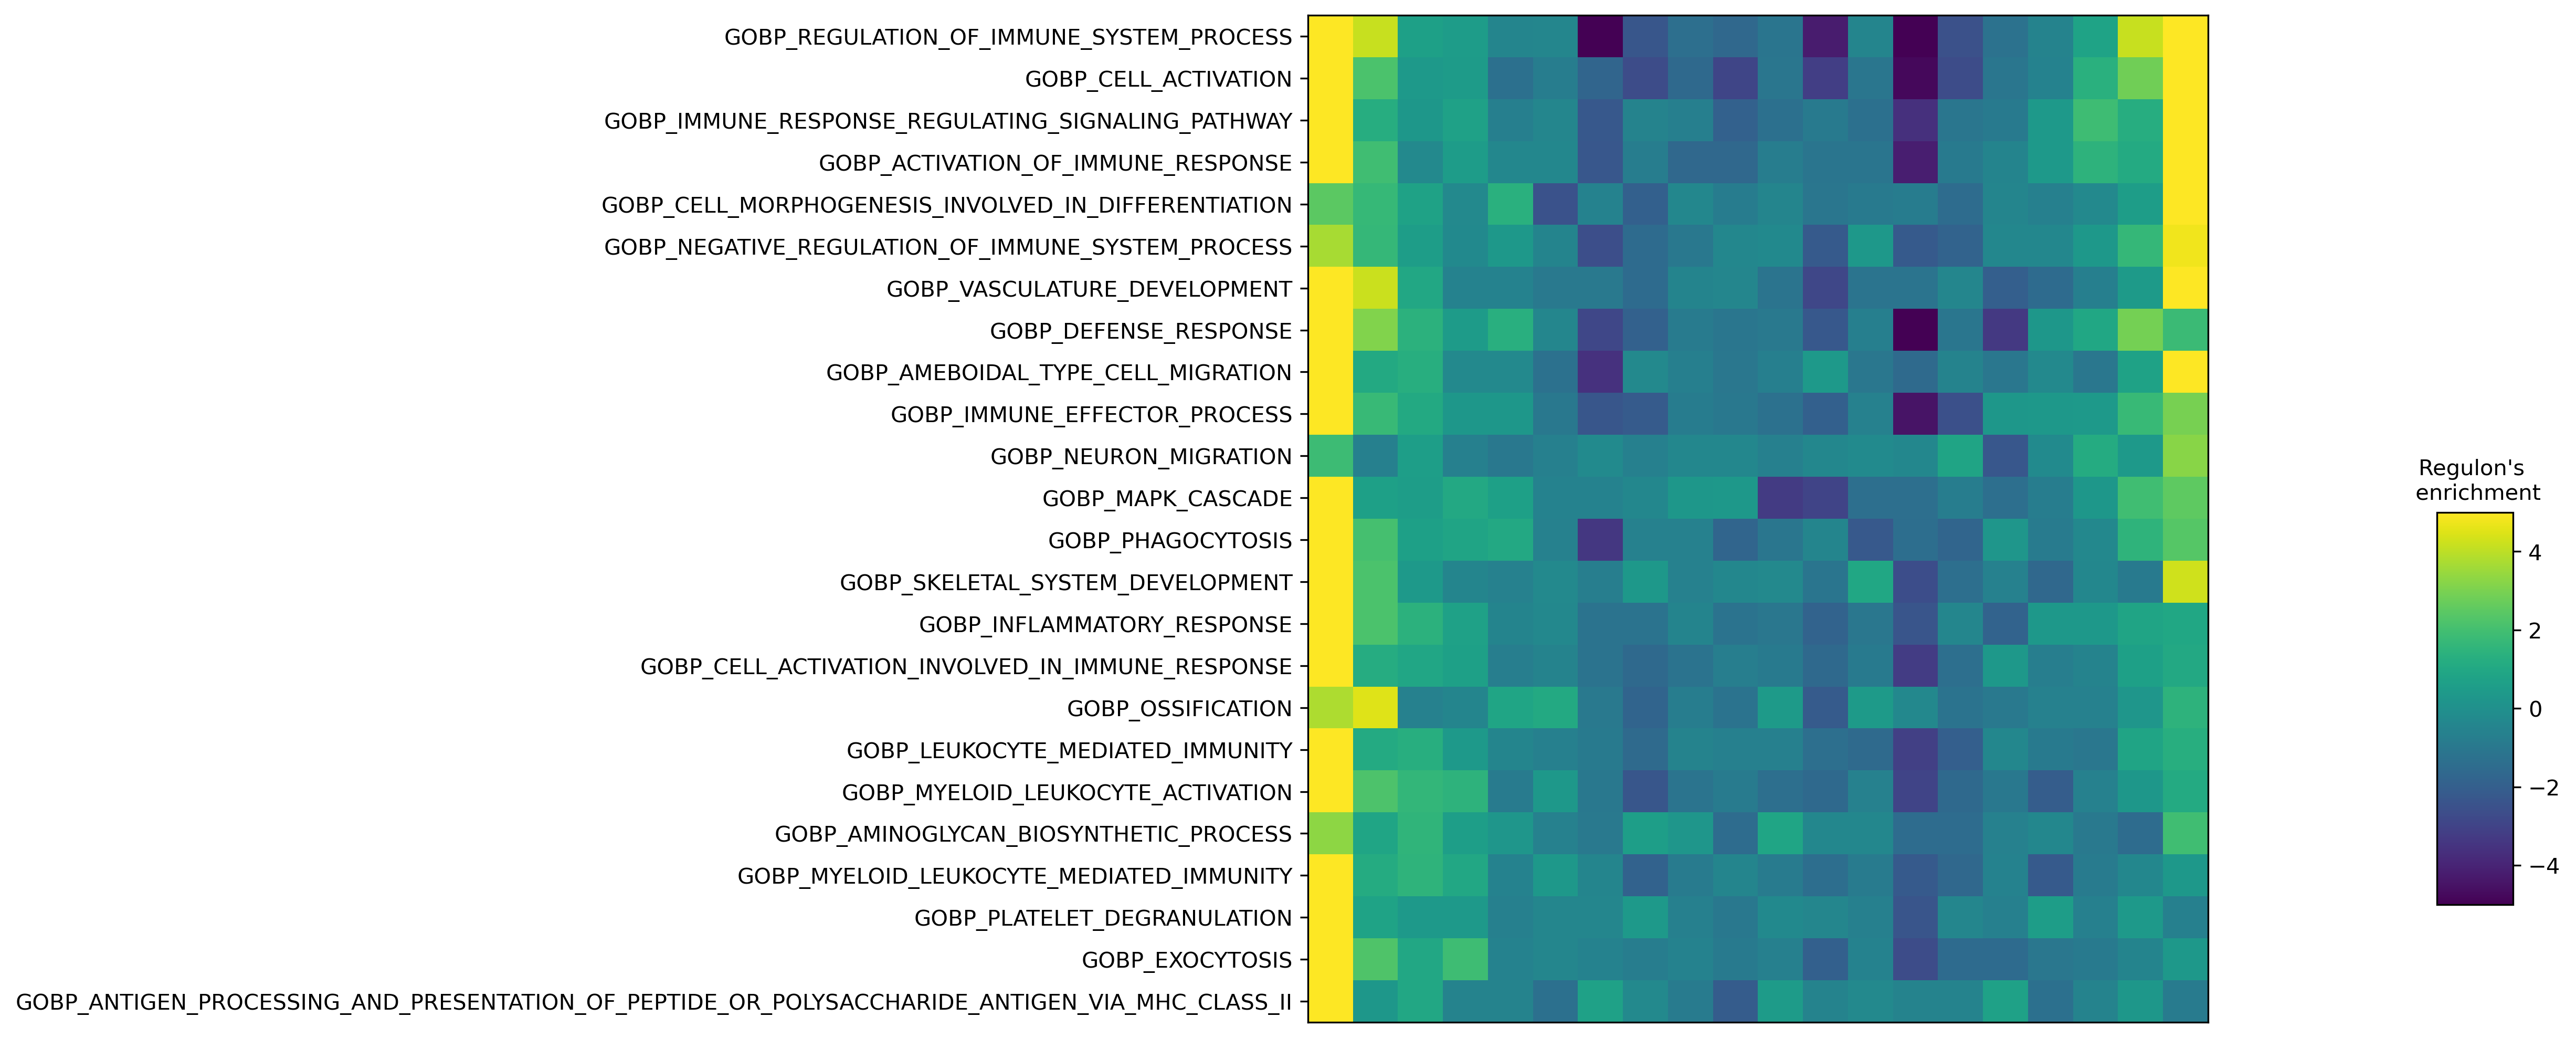

In [38]:
draw_heatmap(
    es_mat.reset_index().drop_duplicates('index').set_index('index')
).show()

#

In [44]:
res_scmultimap['rank'] = res_scmultimap['test_stat'].rank().astype(int)

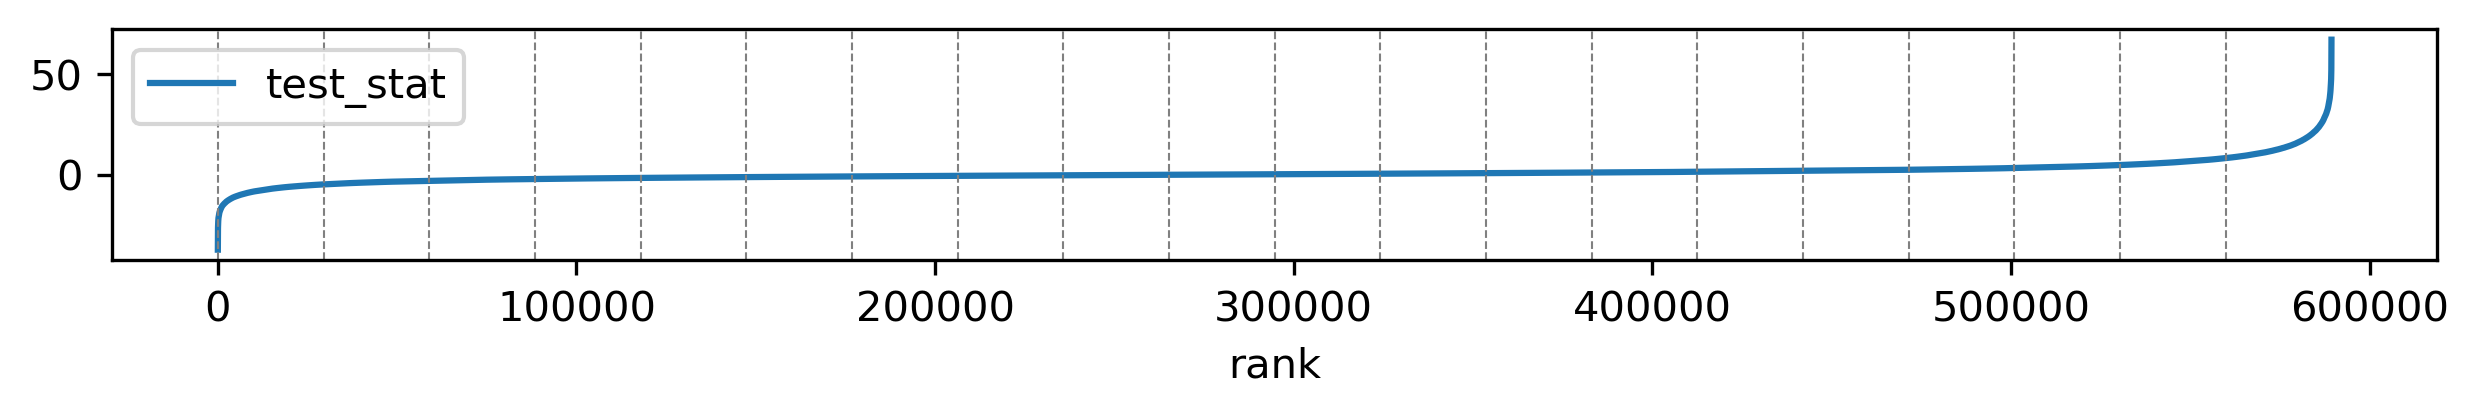

In [55]:
fig, ax = plt.subplots(figsize=(10,1))

res_scmultimap.sort_values('rank')[['rank','test_stat']].plot(x='rank', y='test_stat', ax=ax)

# show 20 bins on the x-axis as lines
for i in range(20):
    ax.axvline(i*res_scmultimap.shape[0]/20, color='gray', linestyle='--', linewidth=0.5)

plt.show()

In [135]:
%%R
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.8 (Ootpa)

Matrix products: default
BLAS/LAPACK: /pollard/home/aabe/miniconda3/envs/SCENT/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.10.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] lubridate_1.9.3                   forcats_1.0.0                    
 [3] stringr_1.5.1                     dplyr_1.1.4                      
 [5] purrr_1.0.2             

In [136]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2024-12-10T12:54:42.369223-08:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 4.18.0-477.27.1.el8_8.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

matplotlib: 3.9.2
pandas    : 2.2.3
numpy     : 2.0.2
IPython   : 8.29.0



___